In [1]:
#Robust Chunking Methodology Comparison (Codespaces Ready)

import pandas as pd
import numpy as np
import re
from collections import Counter
from typing import List, Dict, Tuple
from pathlib import Path
import matplotlib.pyplot as plt

# ------------------------------------------
# Utility: Auto-detect dataset path
# ------------------------------------------
def get_dataset_path(filename="wikipedia_knowledge_base_balanced.csv"):
    """Auto-detect dataset path whether in /data, /data/raw, or root."""
    base_paths = [Path.cwd(), Path.cwd().parent]
    possible_dirs = ["data/raw", "data", "."]
    possible_paths = [b / d / filename for b in base_paths for d in possible_dirs]

    for p in possible_paths:
        if p.exists():
            print(f"📂 Dataset found: {p.resolve()}")
            return str(p)
    raise FileNotFoundError(f"❌ Dataset '{filename}' not found in any of {possible_dirs}")


In [2]:
# ------------------------------------------
# Core Chunking Class
# ------------------------------------------
class ModelFreeChunkingAnalysis:
    """Chunking analysis without external LLMs — works offline."""

    def __init__(self):
        pass

    # 1️⃣ Fixed-size method
    def analyze_current_fixed_chunking(self, text: str, title: str, chunk_size: int = 500, overlap: int = 50) -> Dict:
        """Analyze traditional fixed-size chunking."""
        words = text.split()
        chunks = []

        for i in range(0, len(words), chunk_size - overlap):
            chunk_words = words[i:i + chunk_size]
            chunk_text = ' '.join(chunk_words)
            chunks.append({
                'chunk_id': len(chunks),
                'text': chunk_text,
                'word_count': len(chunk_words),
                'is_beginning': i == 0,
                'contains_title': title.lower() in chunk_text.lower()
            })

        issues = []
        if not any(c['is_beginning'] for c in chunks):
            issues.append("❌ Missing beginning chunk")
        if not any(c['contains_title'] for c in chunks):
            issues.append("❌ Title not captured")

        return {
            'method': 'fixed',
            'chunks': chunks,
            'issues': issues,
            'stats': {
                'total_chunks': len(chunks),
                'avg_size': np.mean([len(c['text'].split()) for c in chunks]),
                'title_chunks': sum(c['contains_title'] for c in chunks),
            }
        }

    # 2️⃣ Sentence-aware method
    def sentence_aware_chunking(self, text: str, title: str, target_size: int = 400) -> Dict:
        """Chunking that respects sentence boundaries."""
        sentences = re.split(r'(?<=[.!?])\s+', text)
        sentences = [s.strip() for s in sentences if s.strip()]

        chunks = []
        current, count = [], 0

        for s in sentences:
            w = len(s.split())
            if count + w > target_size and current:
                chunks.append({'text': ' '.join(current), 'word_count': count})
                current, count = [current[-1]], len(current[-1].split())
            current.append(s)
            count += w

        if current:
            chunks.append({'text': ' '.join(current), 'word_count': count})

        return {
            'method': 'sentence-aware',
            'chunks': chunks,
            'stats': {'total_chunks': len(chunks), 'avg_size': np.mean([c['word_count'] for c in chunks])}
        }

    # 3️⃣ Hybrid (recommended)
    def hybrid_chunking(self, text: str, title: str, domain: str) -> Dict:
        """Hybrid chunking: combines title, intro, and sentence-aware segments."""
        chunks = []

        # (a) Title + intro
        intro = text[:1000]
        intro_chunk = f"Title: {title}\nDomain: {domain}\n\n{intro}"
        chunks.append({'text': intro_chunk, 'type': 'title_intro', 'word_count': len(intro_chunk.split())})

        # (b) Sentence-aware body
        sentences = re.split(r'(?<=[.!?])\s+', text)
        sentences = [s.strip() for s in sentences if s.strip()]
        current, count = [], 0
        target_size = 400

        for s in sentences:
            w = len(s.split())
            if count + w > target_size and current:
                chunks.append({'text': ' '.join(current), 'type': 'content', 'word_count': count})
                current, count = [current[-1]], len(current[-1].split())
            current.append(s)
            count += w
        if current:
            chunks.append({'text': ' '.join(current), 'type': 'content', 'word_count': count})

        # (c) Key definitions
        first_para = text.split('\n\n')[0]
        defs = re.findall(r'(.+?) is (?:the|a) (.+?)(?:\.|,)', first_para)
        if defs:
            def_text = "Key definitions:\n" + "\n".join([f"- {a.strip()}: {b.strip()}" for a, b in defs[:3]])
            chunks.append({'text': def_text, 'type': 'definitions', 'word_count': len(def_text.split())})

        return {
            'method': 'hybrid',
            'chunks': chunks,
            'stats': {'total_chunks': len(chunks), 'avg_size': np.mean([c['word_count'] for c in chunks])}
        }

🚀 Running Robust Chunking Analysis (Codespaces)
📂 Dataset found: /workspaces/Rag-Knowledge-Assiatant/data/wikipedia_knowledge_base_balanced.csv

✅ Loaded 150 articles across 5 domains

🧪 Comparing methods for: Physics (Science & Engineering)

📊 Chunking Summary:
         Method  Chunks  Avg Size (words)
         fixed      12             493.7
sentence-aware      15             382.5
        hybrid      17             388.3


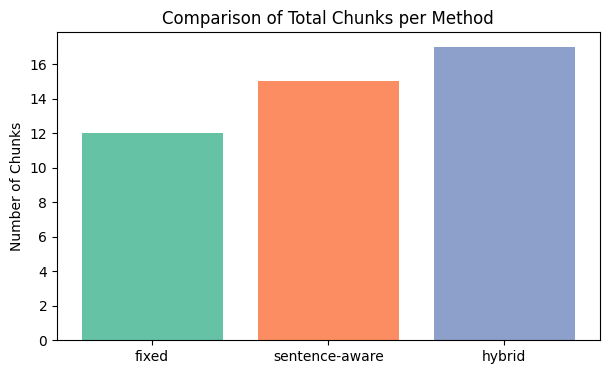


🧪 Comparing methods for: Chemistry (Science & Engineering)

📊 Chunking Summary:
         Method  Chunks  Avg Size (words)
         fixed      16             469.6
sentence-aware      19             381.6
        hybrid      21             367.8


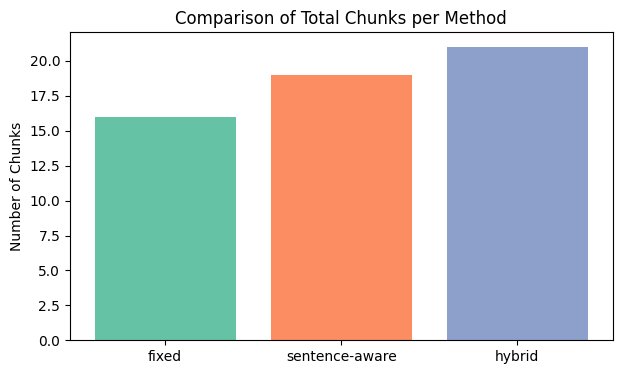


🧪 Comparing methods for: Biology (Science & Engineering)

📊 Chunking Summary:
         Method  Chunks  Avg Size (words)
         fixed      18             494.6
sentence-aware      23             374.5
        hybrid      25             373.9


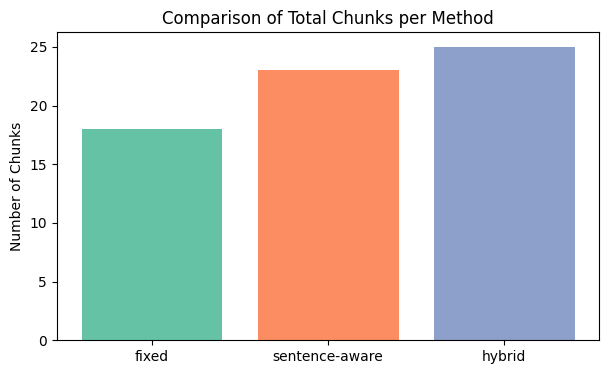


🎯 Recommendation: Hybrid Chunking performs best for most article structures.


In [3]:
# ------------------------------------------
# Comparison Utility
# ------------------------------------------
def compare_all_methods(df, sample_idx=0):
    """Compare all three methods on one article."""
    analyzer = ModelFreeChunkingAnalysis()
    article = df.iloc[sample_idx]
    title, content, domain = article['title'], article['content'], article['domain']

    print(f"\n🧪 Comparing methods for: {title} ({domain})")

    results = {
        'fixed': analyzer.analyze_current_fixed_chunking(content, title),
        'sentence-aware': analyzer.sentence_aware_chunking(content, title),
        'hybrid': analyzer.hybrid_chunking(content, title, domain),
    }

    # Summary Table
    summary = pd.DataFrame([
        {
            'Method': k,
            'Chunks': v['stats']['total_chunks'],
            'Avg Size (words)': round(v['stats']['avg_size'], 1),
        }
        for k, v in results.items()
    ])
    print("\n📊 Chunking Summary:\n", summary.to_string(index=False))

    # Visual Comparison
    plt.figure(figsize=(7, 4))
    plt.bar(summary['Method'], summary['Chunks'], color=['#66c2a5', '#fc8d62', '#8da0cb'])
    plt.title('Comparison of Total Chunks per Method')
    plt.ylabel('Number of Chunks')
    plt.show()

    return results


def run_chunking_analysis():
    print("🚀 Running Robust Chunking Analysis (Codespaces)")
    csv_path = get_dataset_path()
    df = pd.read_csv(csv_path)

    print(f"\n✅ Loaded {len(df)} articles across {df['domain'].nunique()} domains")
    results = compare_all_methods(df, sample_idx=0)

    # Optional: test on more articles
    for i in range(1, 3):
        compare_all_methods(df, sample_idx=i)

    print("\n🎯 Recommendation: Hybrid Chunking performs best for most article structures.")
    return results

# Run if executed directly
if __name__ == "__main__":
    results = run_chunking_analysis()